# TSFS12 Hand-in exercise 3: Path following for autonomous vehicles

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from vehiclecontrol import ControllerBase, SingleTrackModel, PurePursuitControllerBase
from splinepath import SplinePath
from scipy.linalg import solve_discrete_are
import math

In [2]:
# Run if you want plots in external windows
# %matplotlib  

In [3]:
# Run the ipython magic below to activate automated import of modules. Useful if you write code in external .py files.
# %load_ext autoreload
# %autoreload 2

# Make a simple controller and simulate vehicle

In [4]:
class MiniController(ControllerBase):
    def __init__(self):
        super().__init__()
    
    def u(self, t, w):
        a = 0.0
        if t < 10:
            u = [np.pi / 180 * 10, a]
        elif 10 <= t < 20:
            u = [-np.pi / 180 * 11, a]
        elif 20 <= t < 23:
            u = [-np.pi / 180 * 0, a]
        elif 23 <= t < 40:
            u = [-np.pi / 180 * 15, a]
        else:
            u = [-np.pi / 180 * 0, a]
        return u

opts = {'L': 2, 
        'amax': np.inf,
        'amin': -np.inf,
        'steer_limit': np.pi / 3}

car = SingleTrackModel().set_attributes(opts)
car.Ts = 0.1
car.controller = MiniController()
w0 = [0, 0, 0, 2]
z0 = car.simulate(w0, T=40, dt=0.1, t0=0.0)
t, w, u = z0
M = 10
p = w[::M, 0:2]
nom_path = SplinePath(p)

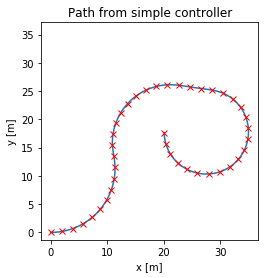

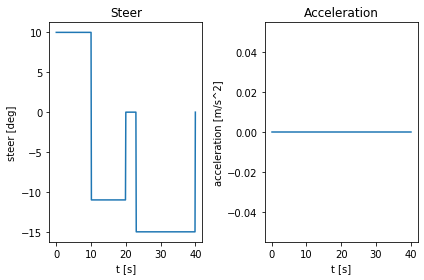

In [5]:
s = np.linspace(0, nom_path.length, 100)

_, ax = plt.subplots(num=10, clear=True)
ax.plot(nom_path.x(s), nom_path.y(s))
ax.plot(p[:, 0], p[:, 1], 'rx')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Path from simple controller')
ax.axis('square')

fig, ax = plt.subplots(1, 2, num=11, clear=True)
ax[0].plot(t, u[:, 0]*180/np.pi)
ax[0].set_xlabel('t [s]')
ax[0].set_ylabel('steer [deg]')
ax[0].set_title('Steer')

ax[1].plot(t, u[:, 1])
ax[1].set_xlabel('t [s]')
ax[1].set_ylabel('acceleration [m/s^2]')
ax[1].set_title('Acceleration')
fig.tight_layout()

# Pure pursuit controller

In [6]:
class PurePursuitController(PurePursuitControllerBase):
    def __init__(self, l, L, path=None, goal_tol=1., pursuit_point_fig=None):
        """
        Create pure-pursuit controller object
        
        Input arguments:
          l -- Prediction horizon
          L -- wheel-base
          path -- SplinePath-object with the path to follow
          goal_tol -- Goal stopping tolerance (default: 1)
          pursuit_point_fig -- Figure object to illustrate pursuit-point selection (default: None)
        """
        super().__init__(pursuit_point_fig)
        self.plan = path
        self.l = l
        self.L = L
        self.goal_tol = goal_tol

        
    def pursuit_point(self, p_car):
        """ Return pure-pursuit given the position of the car.
        
          Input:
            p_car - Car position in global coordinates
            
          Return:
            pursuit point in global coordinates
        """
        # p_car - position of vehicle

        path_points = self.plan.path  # Points on the path
        l = self.l  # Pure-pursuit look-ahead

        # Your code here

        # Hint: It is typically not important to find a point at _exactly_ distance l, 
        #       for example search pure-pursuit point among the points in path_points
        #       but don't forget to take into account the approximate pursuit-horizon when
        #       computing the steering angle.
        dist = np.zeros((len(path_points)))
        for i in range(len(path_points)):
            dp =   p_car[0] - path_points[i]
            dist[i] =  dp.dot(dp)
        closet_path_idx = (np.abs(dist - l)).argmin()
        p_purepursuit = path_points[closet_path_idx]
        return p_purepursuit
    
    def pure_pursuit_control(self, dp, theta):
        """ Compute pure-pursuit steer angle.
        
          Input:
            dp - Vector from position of car to pursuit point
            theta - heading of vehicle
          
          Output:
            return steer angle
        """

        # Your code here to compute new steering angle
        #from internet
        alpha = math.atan2(dp[1], dp[0]) - theta
        delta = math.atan2(2.0 * self.L * math.sin(alpha), self.l)        
        return delta

    def u(self, t, w):
        """ Compute control action
        
          Input:
            t - current time
            w - current state w = (x, y, theta, v)
          
          Output:
            return (delta, acc) where delta is steer angle and acc acceleration
        """
        x, y, theta, v = w
        p_car = np.array([x, y])

        # Your code here to compute steering angle, use the functions
        # self.pursuit_point() and self.pure_pursuit_control() you 
        # have written above.
        p_purepursuit = self.pursuit_point(p_car)
        dp =   p_car - p_purepursuit
        delta = self.pure_pursuit_control(dp, theta)

        acc = 0

        self._pursuit_plot(p_car, p_purepursuit)  # Included for animation purposes.
        
        return np.array([delta, acc])
    
    def run(self, t, w):
        # Function that returns true until goal is reached
        p_goal = self.plan.path[-1, :]
        p_car = w[0:2]
        dp = p_car - p_goal
        dist = dp.dot(dp)        
        
        return dist > self.goal_tol**2

## Assertions

A few tests on your implementation. Note that passing these tests doesn't imply that your solution is correct but do not submit a solution if your solution doesn't pass these tests. First, test the ```pure_pursuit_control``` function

In [7]:
pp_controller = PurePursuitController(l=4, L=car.L, path=nom_path, goal_tol=0.25)
assert abs(pp_controller.pure_pursuit_control(np.array([1., 1.]), 10 * np.pi / 180) - 1.01840) < 1e-3
assert abs(pp_controller.pure_pursuit_control(np.array([1., 1.]), 30 * np.pi / 180) - 0.6319) < 1e-3
assert abs(pp_controller.pure_pursuit_control(np.array([1., 1.]), -30 * np.pi / 180) - 1.2199) < 1e-3

AssertionError: 

To ensure that the pursuit-point selection works, run a simulation with pure-pursuit illustration turned on. Requires plotting in external window.

In [ ]:
s = np.linspace(0, nom_path.length, 200)
fig, ax = plt.subplots(num=99, clear=True)
ax.plot(nom_path.x(s), nom_path.y(s), 'b', lw=0.5)
ax.plot(nom_path.path[:, 0], nom_path.path[:, 1], 'rx', markersize=3)

car = SingleTrackModel()
car.controller = PurePursuitController(l=4, L=car.L, path=nom_path, goal_tol=0.25, pursuit_point_fig=fig)

w0 = [0, 1, np.pi / 2 * 0.9, 2]
z_pp = car.simulate(w0, T=80, dt=0.1, t0=0.0)

## Simulate controller

Simulate controller without visualization

In [ ]:
car = SingleTrackModel()
pp_controller = PurePursuitController(l=4, L=car.L, path=nom_path)
car.controller = pp_controller

w0 = [0, 1, np.pi / 2 * 0.9, 2]  # Sample starting state
z_pp = car.simulate(w0, T=80, dt=0.1, t0=0.0)

# State feedback controller based on the linearized path

Implement linear and non-linear state feedback control.

In [ ]:
class StateFeedbackController(ControllerBase):
    def __init__(self, K, L, path=None, goal_tol=1.):
        super().__init__()
        self.plan = path
        self.K = K
        self.goal_tol = goal_tol
        self.d = []
        self.L = L
        self.s0 = 0

    def heading_error(self, theta, s):
        """Compute theta error
        Inputs
            theta - current heading angle
            s - projection point on path
            
        Outputs
            theta_e - heading error angle
        """
            
        # YOUR CODE HERE
        theta_e = 0.0
        return theta_e

    def u(self, t, w):
        x, y, theta, v = w
        p_car = w[0:2]

        # Compute d and theta_e errors. Use the SplinePath method project
        # and the obj.heading_error() function you've written above

        # YOUR CODE HERE
        d = 0
        theta_e = 0

        # Compute control signal delta
        acc = 0  # Constant speed
        delta = 0  # Steering angle

        return np.array([delta, acc])
    
    def run(self, t, w):
        p_goal = self.plan.path[-1, :]
        p_car = w[0:2]
        dp = p_car - p_goal
        dist = np.sqrt(dp.dot(dp))
        
        return dist > self.goal_tol**2
